### Shared code between different datasets

In [ ]:
# All necessary imports to run data on U-Net base
import numpy as np
import gdown
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import tensorflow.keras.backend as K
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models

from scipy.signal import find_peaks
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoding path
    c1 = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv1D(64, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling1D(pool_size=2)(c1)  # Now (312, 64)
    #print(f"p1 shape: {p1.shape}")

    c2 = layers.Conv1D(128, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv1D(128, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling1D(pool_size=2)(c2)  # Now (156, 128)
    #print(f"p2 shape: {p2.shape}")

    c3 = layers.Conv1D(256, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv1D(256, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling1D(pool_size=2)(c3)  # Now (78, 256)
    #print(f"p3 shape: {p3.shape}")

    c4 = layers.Conv1D(512, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv1D(512, 3, activation='relu', padding='same')(c4)  # Now (78, 512)
    #print(f"c4 shape: {c4.shape}")

    # Decoding path
    u5 = layers.UpSampling1D(size=2)(c4)  # Now (156, 512)
    #print(f"u5 shape: {u5.shape}")
    u5 = layers.concatenate([u5, c3])  # Match c3 shape (156, 256)
    c5 = layers.Conv1D(256, 3, activation='relu', padding='same')(u5)
    c5 = layers.Conv1D(256, 3, activation='relu', padding='same')(c5)

    u6 = layers.UpSampling1D(size=2)(c5)  # Now (312, 256)
    #print(f"u6 shape: {u6.shape}")
    u6 = layers.concatenate([u6, c2])  # Match c2 shape (312, 128)
    c6 = layers.Conv1D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv1D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.UpSampling1D(size=2)(c6)  # Now (624, 128)
    #print(f"u7 shape: {u7.shape}")
    u7 = layers.ZeroPadding1D(padding=(0, 1))(u7)  # Pad to (625, 128) to match input shape (625, 2)
    #print(f"u7 shape: {u7.shape}")
    u7 = layers.concatenate([u7, c1])  # Concatenate with c1 (625, 64)
    #print(f"u7 shape: {u7.shape}")
    c7 = layers.Conv1D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv1D(64, 3, activation='relu', padding='same')(c7)

    # Output layer
    outputs = layers.Conv1D(1, 1, activation='linear', padding='same')(c7)

    model = models.Model(inputs, outputs)
    return model

In [ ]:
def accumulate_episodes(data, signal_type):
    """
    Accumulate episodes from all records into a single dataset, ensuring uniform length.

    Parameters:
    - data (dict): Filtered dataset (e.g., butterworth_data).
    - signal_type (str): Type of signal to accumulate ('filtered_ecg' or 'filtered_abp').

    Returns:
    - accumulated_data (np.array): Array of shape (total_episodes, 625).
    """
    accumulated_data = []

    for record_id in data.keys():  # Loop through each record
        for episode in data[record_id][signal_type]:  # Loop through each 10-second episode
            if len(episode) == 625:  # Ensure the episode has 625 points
                accumulated_data.append(episode)  # Add the episode to the list
            #else:
                #print(f"Skipping episode with invalid length: {len(episode)} (Record: {record_id})")

    return np.array(accumulated_data)  # Convert list to numpy array


def extract_sbp_dbp(signal):
    """
    Extract SBP (max peak) and DBP (min between peaks) from a single ABP waveform.
    :param signal: 1D array representing the ABP waveform (e.g., 625 samples).
    :return: SBP (max peak) and DBP (min between peaks).
    """
    peaks, _ = find_peaks(signal)
    sbp = signal[peaks].max() if len(peaks) > 0 else signal.max()

    valleys, _ = find_peaks(-signal)  # Flip the signal to find minima
    dbp = signal[valleys].min() if len(valleys) > 0 else signal.min()

    return sbp, dbp


def calculate_error_metrics(y_true, y_pred):
    """
    Calculate MAE, RMSE, and ME ± SD for SBP and DBP.
    :param y_true: 1D array of true values (SBP or DBP).
    :param y_pred: 1D array of predicted values (SBP or DBP).
    :return: MAE, RMSE, ME ± SD (Mean Error and Standard Deviation of error).
    """
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_error = np.mean(y_pred - y_true)
    std_error = np.std(y_pred - y_true)

    return mae, rmse, mean_error, std_error


def bhs_grades(errors):
    """
    Compute BHS grading based on SBP/DBP errors.
    :param errors: Array of absolute errors (SBP or DBP).
    :return: BHS grading (A, B, C, or Fail).
    """
    errors = np.abs(np.array(errors).flatten())
    within_5 = np.mean(errors <= 5) * 100
    within_10 = np.mean(errors <= 10) * 100
    within_15 = np.mean(errors <= 15) * 100

    if within_5 >= 60 and within_10 >= 85 and within_15 >= 95:
        print(f"within_5: {within_5}, within_10: {within_10}, within_15: {within_15}")
        return "A"
    elif within_5 >= 50 and within_10 >= 75 and within_15 >= 90:
        print(f"within_5: {within_5}, within_10: {within_10}, within_15: {within_15}")
        return "B"
    elif within_5 >= 40 and within_10 >= 65 and within_15 >= 85:
        print(f"within_5: {within_5}, within_10: {within_10}, within_15: {within_15}")
        return "C"
    else:
        print(f"within_5: {within_5}, within_10: {within_10}, within_15: {within_15}")
        return "Fail"


def calculate_sbp_dbp_errors(y_test_original, y_pred_original):
    """
    Calculate MAE, RMSE, ME ± SD, and BHS Evaluation for SBP and DBP.
    :param y_test_original: 2D array of ground truth ABP waveforms (shape: [n_samples, 625]).
    :param y_pred_original: 2D array of predicted ABP waveforms (shape: [n_samples, 625]).
    :return: Dictionary with SBP and DBP errors (MAE, RMSE, ME ± SD, BHS grades).
    """
    sbp_true, dbp_true = [], []
    sbp_pred, dbp_pred = [], []

    # Loop through each waveform and extract SBP/DBP
    for i in range(len(y_test_original)):
        sbp_t, dbp_t = extract_sbp_dbp(y_test_original[i])
        sbp_p, dbp_p = extract_sbp_dbp(y_pred_original[i])

        sbp_true.append(sbp_t)
        dbp_true.append(dbp_t)
        sbp_pred.append(sbp_p)
        dbp_pred.append(dbp_p)

    # Convert to NumPy arrays for calculation
    sbp_true, dbp_true = np.array(sbp_true), np.array(dbp_true)
    sbp_pred, dbp_pred = np.array(sbp_pred), np.array(dbp_pred)

    # Calculate errors for SBP and DBP
    sbp_mae, sbp_rmse, sbp_me, sbp_sd = calculate_error_metrics(sbp_true, sbp_pred)
    dbp_mae, dbp_rmse, dbp_me, dbp_sd = calculate_error_metrics(dbp_true, dbp_pred)

    # Calculate BHS Grades
    sbp_bhs = bhs_grades(np.abs(sbp_pred - sbp_true))
    dbp_bhs = bhs_grades(np.abs(dbp_pred - dbp_true))

    # Return results
    return {
        "SBP_MAE": sbp_mae,
        "DBP_MAE": dbp_mae,
        "SBP_RMSE": sbp_rmse,
        "DBP_RMSE": dbp_rmse,
        "SBP_ME ± SD": f"{sbp_me:.2f} ± {sbp_sd:.2f}",
        "DBP_ME ± SD": f"{dbp_me:.2f} ± {dbp_sd:.2f}",
        "SBP_BHS_Grade": sbp_bhs,
        "DBP_BHS_Grade": dbp_bhs
    }

### Cross-validation code and error computation

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

def cross_validate_unet(X, y, n_splits=5, epochs=100, batch_size=256, random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Scaling
    scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
    X_train_val_scaled = scaler_X.fit_transform(X_train_val).reshape(-1, 625, 1)
    y_train_val_scaled = scaler_y.fit_transform(y_train_val).reshape(-1, 625, 1)
    X_test_scaled = scaler_X.transform(X_test).reshape(-1, 625, 1)
    y_test_scaled = scaler_y.transform(y_test).reshape(-1, 625, 1)

    cv_scores_rmse, cv_scores_mae = [], []
    train_rmse_rescaled_all, train_mae_rescaled_all = [], []
    y_val_ground_all, y_val_pred_all = [], []
    y_train_ground_all, y_train_pred_all = [], []
    train_losses, val_losses = [], []
    train_maes, val_maes = [], []


    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_val_scaled)):
        print(f"Training fold {fold + 1}...")
        X_train, X_val = X_train_val_scaled[train_idx], X_train_val_scaled[val_idx]
        y_train, y_val = y_train_val_scaled[train_idx], y_train_val_scaled[val_idx]

        model = unet(input_shape=(625, 1))
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', rmse])

        history = model.fit(
            X_train, y_train, validation_data=(X_val, y_val),
            epochs=epochs, batch_size=batch_size, verbose=1)#, callbacks=[early_stopping])

        train_losses.append(history.history['loss'])
        val_losses.append(history.history['val_loss'])
        train_maes.append(history.history['mae'])
        val_maes.append(history.history['val_mae'])

        scores = model.evaluate(X_val, y_val, verbose=0)
        print(f"Fold {fold + 1} - Validation MAE: {scores[1]:.4f}, Validation RMSE: {scores[2]:.4f}")

        # Validation set predictions
        y_pred_rescaled = scaler_y.inverse_transform(model.predict(X_val).reshape(-1, 625))
        y_true_rescaled = scaler_y.inverse_transform(y_val.reshape(-1, 625))
        y_val_ground_all.append(y_true_rescaled)
        y_val_pred_all.append(y_pred_rescaled)
        cv_scores_rmse.append(np.sqrt(np.mean((y_pred_rescaled - y_true_rescaled) ** 2)))
        cv_scores_mae.append(np.mean(np.abs(y_pred_rescaled - y_true_rescaled)))

        # Train set predictions
        y_pred_train_rescaled = scaler_y.inverse_transform(model.predict(X_train).reshape(-1, 625))
        y_true_train_rescaled = scaler_y.inverse_transform(y_train.reshape(-1, 625))
        train_rmse_rescaled_all.append(np.sqrt(np.mean((y_pred_train_rescaled - y_true_train_rescaled) ** 2)))
        train_mae_rescaled_all.append(np.mean(np.abs(y_pred_train_rescaled - y_true_train_rescaled)))
        y_train_ground_all.append(y_true_train_rescaled)
        y_train_pred_all.append(y_pred_train_rescaled)

    # Save results
    np.save("y_val_ground_cv.npy", np.vstack(y_val_ground_all))
    np.save("y_val_pred_cv.npy", np.vstack(y_val_pred_all))
    np.save("y_train_ground_cv.npy", np.vstack(y_train_ground_all))
    np.save("y_train_pred_cv.npy", np.vstack(y_train_pred_all))

    print(f"\nAverage Rescaled Train RMSE: {np.mean(train_rmse_rescaled_all):.4f} ± {np.std(train_rmse_rescaled_all):.4f}")
    print(f"Average Rescaled Train MAE: {np.mean(train_mae_rescaled_all):.4f} ± {np.std(train_mae_rescaled_all):.4f}")
    print(f"\nAverage Rescaled Validation RMSE: {np.mean(cv_scores_rmse):.4f} ± {np.std(cv_scores_rmse):.4f}")
    print(f"Average Rescaled Validation MAE: {np.mean(cv_scores_mae):.4f} ± {np.std(cv_scores_mae):.4f}")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_maes": train_maes,
        "val_maes": val_maes
    }

In [ ]:
def evaluate_cv_results(y_test_path="y_test_ground_cv.npy", y_pred_path="y_predicted_cv.npy"):
    """
    Load cross-validation results, compute errors, and print evaluation metrics.

    Parameters:
        y_test_path (str): Path to the saved ground truth values.
        y_pred_path (str): Path to the saved predicted values.
    """
    # Load predictions and ground truth
    y_test_ground_all_cv = np.load(y_test_path)
    y_predicted_all_cv = np.load(y_pred_path)

    # Compute mean and standard deviation of errors
    mean_error = np.mean(y_predicted_all_cv - y_test_ground_all_cv)
    std_error = np.std(y_predicted_all_cv - y_test_ground_all_cv)

    # Compute BHS grades
    bhs_map = bhs_grades(y_predicted_all_cv - y_test_ground_all_cv)

    print(f"Evaluation Results for MAP from CV")
    print(f"ME ± SD MAP (CV): {mean_error:.4f} ± {std_error:.4f}")
    print(f"BHS MAP (CV): {bhs_map}")

    # Calculate SBP and DBP errors
    results = calculate_sbp_dbp_errors(y_test_ground_all_cv, y_predicted_all_cv)

    print("\n--- Evaluation Results ---")
    print(f"SBP MAE: {results['SBP_MAE']:.2f}")
    print(f"DBP MAE: {results['DBP_MAE']:.2f}")
    print(f"SBP RMSE: {results['SBP_RMSE']:.2f}")
    print(f"DBP RMSE: {results['DBP_RMSE']:.2f}")
    print(f"SBP ME ± SD: {results['SBP_ME ± SD']}")
    print(f"DBP ME ± SD: {results['DBP_ME ± SD']}")
    print(f"SBP BHS Grade: {results['SBP_BHS_Grade']}")
    print(f"DBP BHS Grade: {results['DBP_BHS_Grade']}")


## Testing Butterworth dataset

In [ ]:
but_data = np.load("butterworth_dataset.npy", allow_pickle=True).item()

ecg_but = accumulate_episodes(but_data, signal_type='filtered_ecg')
abp_but = accumulate_episodes(but_data, signal_type='filtered_abp')

print(f"Shapes of ECG: {ecg_but.shape}")
print(f"Shapes of ABP: {abp_but.shape}")

Shapes of ECG: (25319, 625)
Shapes of ABP: (25319, 625)


In [ ]:
X = ecg_but
y = abp_but

print(f"X shape {X.shape}")
print(f"y shape is {y.shape}")

X shape (25319, 625)
y shape is (25319, 625)


In [ ]:
results = cross_validate_unet(X,y)

Training fold 1...
Epoch 1/100
64/64 [==============================] - 39s 509ms/step - loss: 0.0315 - mae: 0.1399 - rmse: 0.1753 - val_loss: 0.0282 - val_mae: 0.1341 - val_rmse: 0.1678
Epoch 2/100
64/64 [==============================] - 31s 489ms/step - loss: 0.0275 - mae: 0.1330 - rmse: 0.1657 - val_loss: 0.0274 - val_mae: 0.1316 - val_rmse: 0.1655
Epoch 3/100
64/64 [==============================] - 31s 490ms/step - loss: 0.0233 - mae: 0.1186 - rmse: 0.1521 - val_loss: 0.0197 - val_mae: 0.1055 - val_rmse: 0.1402
Epoch 4/100
64/64 [==============================] - 31s 491ms/step - loss: 0.0165 - mae: 0.0952 - rmse: 0.1283 - val_loss: 0.0157 - val_mae: 0.0913 - val_rmse: 0.1251
Epoch 5/100
64/64 [==============================] - 31s 492ms/step - loss: 0.0139 - mae: 0.0862 - rmse: 0.1177 - val_loss: 0.0136 - val_mae: 0.0835 - val_rmse: 0.1166
Epoch 6/100
64/64 [==============================] - 32s 497ms/step - loss: 0.0126 - mae: 0.0814 - rmse: 0.1121 - val_loss: 0.0123 - val_mae:

In [ ]:
train_losses = results["train_losses"]
val_losses = results["val_losses"]
train_maes = results["train_maes"]
val_maes = results["val_maes"]

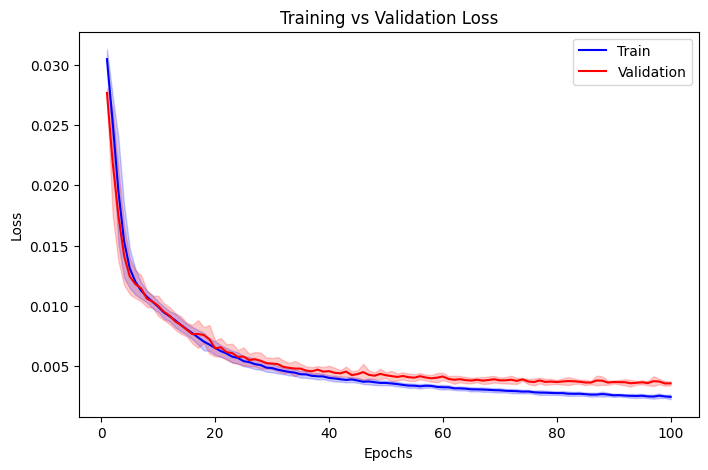

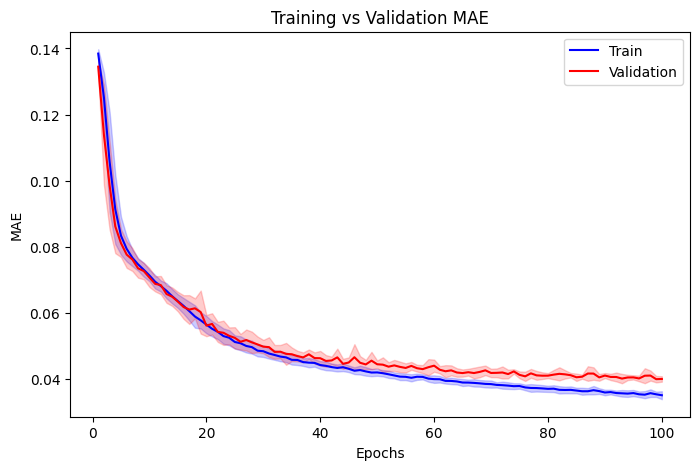

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_losses, val_losses, train_maes, val_maes are lists of lists (one per fold)
train_losses = np.array(train_losses)  # Shape: (n_folds, n_epochs)
val_losses = np.array(val_losses)
train_maes = np.array(train_maes)
val_maes = np.array(val_maes)

epochs = np.arange(1, train_losses.shape[1] + 1)

def plot_metric(train_metric, val_metric, ylabel, title):
    mean_train = np.mean(train_metric, axis=0)
    std_train = np.std(train_metric, axis=0)
    mean_val = np.mean(val_metric, axis=0)
    std_val = np.std(val_metric, axis=0)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, mean_train, label="Train", color="blue")
    plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, color="blue", alpha=0.2)

    plt.plot(epochs, mean_val, label="Validation", color="red")
    plt.fill_between(epochs, mean_val - std_val, mean_val + std_val, color="red", alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Loss Curve
plot_metric(train_losses, val_losses, ylabel="Loss", title="Training vs Validation Loss")

# Plot MAE Curve
plot_metric(train_maes, val_maes, ylabel="MAE", title="Training vs Validation MAE")


#### Train set errors

In [ ]:
evaluate_cv_results(y_test_path="y_train_ground_cv.npy", y_pred_path="y_train_pred_cv.npy")

within_5: 72.22305998518884, within_10: 93.33912614169341, within_15: 98.07419402616638
Evaluation Results for MAP from CV
ME ± SD MAP (CV): 0.3424 ± 5.6041
BHS MAP (CV): A
within_5: 51.88471982226611, within_10: 81.7316711922982, within_15: 94.51493458405332
within_5: 86.26758824981486, within_10: 97.38212786966182, within_15: 98.83979264379165

--- Evaluation Results ---
SBP MAE: 5.99
DBP MAE: 3.00
SBP RMSE: 7.89
DBP RMSE: 4.58
SBP ME ± SD: 2.95 ± 7.32
DBP ME ± SD: -0.02 ± 4.58
SBP BHS Grade: B
DBP BHS Grade: A


#### Validation set errors

In [ ]:
evaluate_cv_results(y_test_path="y_val_ground_cv.npy", y_pred_path="y_val_pred_cv.npy")

within_5: 68.6164522340163, within_10: 90.58489064428537, within_15: 96.4037956060232
Evaluation Results for MAP from CV
ME ± SD MAP (CV): 0.2804 ± 6.7956
BHS MAP (CV): A
within_5: 46.86744013823747, within_10: 75.69489015058011, within_15: 89.8049864231054
within_5: 84.36435448037521, within_10: 96.65761540360404, within_15: 98.45470254258207

--- Evaluation Results ---
SBP MAE: 7.13
DBP MAE: 3.22
SBP RMSE: 9.80
DBP RMSE: 5.24
SBP ME ± SD: 3.75 ± 9.05
DBP ME ± SD: -0.18 ± 5.23
SBP BHS Grade: C
DBP BHS Grade: A


### Test set errors

In [ ]:
print(f"X shape {X.shape}")
print(f"y shape is {y.shape}")

X shape (25319, 625)
y shape is (25319, 625)


In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [ ]:
# Final Model Training on Entire Training Data (80% of data)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))


# Normalize using Min-Max Normalization on the entire training data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train).reshape(-1, 625, 1)
X_val_scaled = scaler_X.transform(X_val).reshape(-1, 625, 1)  # Only transform!
X_test_scaled = scaler_X.transform(X_test).reshape(-1, 625, 1)  # Only transform!

y_train_scaled = scaler_y.fit_transform(y_train).reshape(-1, 625, 1)
y_val_scaled = scaler_y.transform(y_val).reshape(-1, 625, 1)  # Only transform!
y_test_scaled = scaler_y.transform(y_test).reshape(-1, 625, 1)  # Only transform!
# Initialize the model (make sure unet is defined)
model = unet(input_shape=(625, 1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', rmse])

# Train the model on the entire training set (80%)
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled),
                    epochs=100, batch_size=256, verbose=1)#, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_mae, test_rmse = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

# Rescale the predictions and true values to the original scale
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 625))
y_test_true_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 625))

# Calculate final RMSE and MAE on the original scale
final_mae = np.mean(np.abs(y_test_pred_rescaled - y_test_true_rescaled))
final_rmse = np.sqrt(np.mean((y_test_pred_rescaled - y_test_true_rescaled) ** 2))

# Print final evaluation results
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Final Rescaled MAE on Test Set: {final_mae:.4f}")
print(f"Final Rescaled RMSE on Test Set: {final_rmse:.4f}")

# Save the final predictions and true values on the test set
np.save("final_y_test_ground.npy", y_test_true_rescaled)
np.save("final_y_test_predicted.npy", y_test_pred_rescaled)

Epoch 1/100
64/64 [==============================] - 35s 496ms/step - loss: 0.0304 - mae: 0.1386 - rmse: 0.1730 - val_loss: 0.0283 - val_mae: 0.1329 - val_rmse: 0.1684
Epoch 2/100
64/64 [==============================] - 31s 493ms/step - loss: 0.0257 - mae: 0.1264 - rmse: 0.1600 - val_loss: 0.0212 - val_mae: 0.1122 - val_rmse: 0.1455
Epoch 3/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0171 - mae: 0.0971 - rmse: 0.1304 - val_loss: 0.0161 - val_mae: 0.0902 - val_rmse: 0.1270
Epoch 4/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0136 - mae: 0.0849 - rmse: 0.1163 - val_loss: 0.0135 - val_mae: 0.0858 - val_rmse: 0.1160
Epoch 5/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0120 - mae: 0.0793 - rmse: 0.1094 - val_loss: 0.0121 - val_mae: 0.0812 - val_rmse: 0.1101
Epoch 6/100
64/64 [==============================] - 32s 496ms/step - loss: 0.0111 - mae: 0.0761 - rmse: 0.1053 - val_loss: 0.0111 - val_mae: 0.0748 - val_rmse:

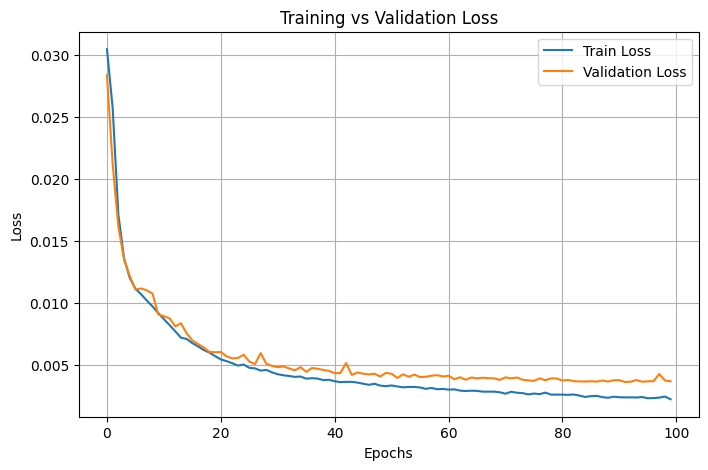

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
y_test_ground_all = np.load("final_y_test_ground.npy")
y_predicted_all = np.load("final_y_test_predicted.npy")

mean_error = np.mean(y_predicted_all - y_test_ground_all)
std_error = np.std(y_predicted_all - y_test_ground_all)

bhs_map = bhs_grades((y_predicted_all - y_test_ground_all))

print(f"Evaluation Results for MAP (test set)")
print(f"ME ± SD MAP (test set): {mean_error:.4f} ± {std_error:.4f}")
print(f"BHS MAP (test set): {bhs_map}")

results = calculate_sbp_dbp_errors(y_test_ground_all, y_predicted_all)

print("\n--- Evaluation Results from Test Set ---")
print(f"SBP MAE: {results['SBP_MAE']:.2f}")
print(f"DBP MAE: {results['DBP_MAE']:.2f}")
print(f"SBP RMSE: {results['SBP_RMSE']:.2f}")
print(f"DBP RMSE: {results['DBP_RMSE']:.2f}")
print(f"SBP ME ± SD: {results['SBP_ME ± SD']}")
print(f"DBP ME ± SD: {results['DBP_ME ± SD']}")
print(f"SBP BHS Grade: {results['SBP_BHS_Grade']}")
print(f"DBP BHS Grade: {results['DBP_BHS_Grade']}")

within_5: 68.91601895734597, within_10: 90.78199052132702, within_15: 96.46654028436019
Evaluation Results for MAP (test set)
ME ± SD MAP (test set): 0.4542 ± 6.6974
BHS MAP (test set): A
within_5: 46.860189573459714, within_10: 74.7432859399684, within_15: 89.41548183254343
within_5: 84.4391785150079, within_10: 96.6824644549763, within_15: 98.59794628751975

--- Evaluation Results from Test Set ---
SBP MAE: 7.31
DBP MAE: 3.21
SBP RMSE: 10.14
DBP RMSE: 4.85
SBP ME ± SD: 4.49 ± 9.10
DBP ME ± SD: -0.08 ± 4.85
SBP BHS Grade: C
DBP BHS Grade: A


## Testing Butterworth + MAF

In [ ]:
but_maf_data = np.load("butterworth_maf_dataset.npy", allow_pickle=True).item()

ecg_bm = accumulate_episodes(but_maf_data, signal_type='filtered_ecg')
abp_bm = accumulate_episodes(but_maf_data, signal_type='filtered_abp')

print(f"Shapes of ECG: {ecg_bm.shape}")
print(f"Shapes of ABP: {abp_bm.shape}")

Shapes of ECG: (25319, 625)
Shapes of ABP: (25319, 625)


In [ ]:
X = ecg_bm
y = abp_bm

print(f"X shape {X.shape}")
print(f"y shape is {y.shape}")

X shape (25319, 625)
y shape is (25319, 625)


In [ ]:
results = cross_validate_unet(X, y)

Training fold 1...
Epoch 1/100
64/64 [==============================] - 35s 498ms/step - loss: 0.0294 - mae: 0.1367 - rmse: 0.1704 - val_loss: 0.0277 - val_mae: 0.1333 - val_rmse: 0.1666
Epoch 2/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0240 - mae: 0.1212 - rmse: 0.1543 - val_loss: 0.0187 - val_mae: 0.1018 - val_rmse: 0.1368
Epoch 3/100
64/64 [==============================] - 32s 496ms/step - loss: 0.0160 - mae: 0.0937 - rmse: 0.1262 - val_loss: 0.0140 - val_mae: 0.0872 - val_rmse: 0.1182
Epoch 4/100
64/64 [==============================] - 32s 496ms/step - loss: 0.0128 - mae: 0.0822 - rmse: 0.1130 - val_loss: 0.0124 - val_mae: 0.0798 - val_rmse: 0.1110
Epoch 5/100
64/64 [==============================] - 32s 496ms/step - loss: 0.0116 - mae: 0.0778 - rmse: 0.1074 - val_loss: 0.0113 - val_mae: 0.0763 - val_rmse: 0.1063
Epoch 6/100
64/64 [==============================] - 32s 496ms/step - loss: 0.0109 - mae: 0.0751 - rmse: 0.1040 - val_loss: 0.0111 - val_mae:

In [ ]:
train_losses = results["train_losses"]
val_losses = results["val_losses"]
train_maes = results["train_maes"]
val_maes = results["val_maes"]

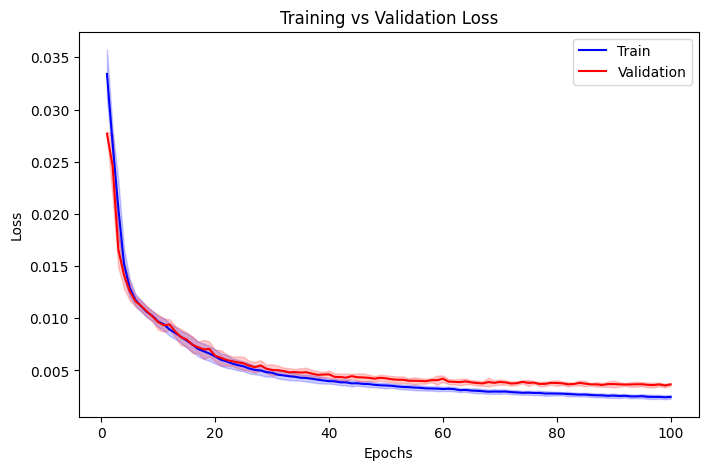

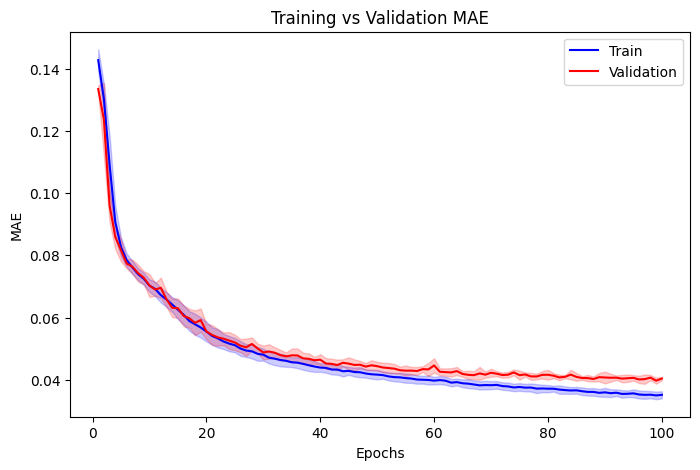

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_losses, val_losses, train_maes, val_maes are lists of lists (one per fold)
train_losses = np.array(train_losses)  # Shape: (n_folds, n_epochs)
val_losses = np.array(val_losses)
train_maes = np.array(train_maes)
val_maes = np.array(val_maes)

epochs = np.arange(1, train_losses.shape[1] + 1)

def plot_metric(train_metric, val_metric, ylabel, title):
    mean_train = np.mean(train_metric, axis=0)
    std_train = np.std(train_metric, axis=0)
    mean_val = np.mean(val_metric, axis=0)
    std_val = np.std(val_metric, axis=0)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, mean_train, label="Train", color="blue")
    plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, color="blue", alpha=0.2)

    plt.plot(epochs, mean_val, label="Validation", color="red")
    plt.fill_between(epochs, mean_val - std_val, mean_val + std_val, color="red", alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Loss Curve
plot_metric(train_losses, val_losses, ylabel="Loss", title="Training vs Validation Loss")

# Plot MAE Curve
plot_metric(train_maes, val_maes, ylabel="MAE", title="Training vs Validation MAE")

#### Train set errors

In [ ]:
evaluate_cv_results(y_test_path="y_train_ground_cv.npy", y_pred_path="y_train_pred_cv.npy")

within_5: 72.03832337694396, within_10: 93.27679881510737, within_15: 98.03421969883979
Evaluation Results for MAP from CV
ME ± SD MAP (CV): -0.0996 ± 5.6371
BHS MAP (CV): A
within_5: 54.881510738089354, within_10: 84.63589237225376, within_15: 95.56158973093063
within_5: 86.25524561836583, within_10: 97.33399160701062, within_15: 98.78301653912615

--- Evaluation Results ---
SBP MAE: 5.62
DBP MAE: 3.04
SBP RMSE: 7.48
DBP RMSE: 4.62
SBP ME ± SD: 1.46 ± 7.33
DBP ME ± SD: -0.10 ± 4.62
SBP BHS Grade: B
DBP BHS Grade: A


#### Validation set errors

In [ ]:
evaluate_cv_results(y_test_path="y_val_ground_cv.npy", y_pred_path="y_val_pred_cv.npy")

within_5: 68.3023687978277, within_10: 90.40727524068132, within_15: 96.28672031597137
Evaluation Results for MAP from CV
ME ± SD MAP (CV): -0.1695 ± 6.8806
BHS MAP (CV): A
within_5: 48.45717106887189, within_10: 78.22759812392002, within_15: 91.08368304122439
within_5: 84.79387805480128, within_10: 96.80572698099235, within_15: 98.38558380646754

--- Evaluation Results ---
SBP MAE: 6.80
DBP MAE: 3.24
SBP RMSE: 9.39
DBP RMSE: 5.26
SBP ME ± SD: 2.28 ± 9.11
DBP ME ± SD: -0.28 ± 5.25
SBP BHS Grade: C
DBP BHS Grade: A


### Test set errors

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

# Final Model Training on Entire Training Data (80% of data)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))


#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Normalize using Min-Max Normalization on the entire training data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train).reshape(-1, 625, 1)
X_val_scaled = scaler_X.transform(X_val).reshape(-1, 625, 1)  # Only transform!
X_test_scaled = scaler_X.transform(X_test).reshape(-1, 625, 1)  # Only transform!

y_train_scaled = scaler_y.fit_transform(y_train).reshape(-1, 625, 1)
y_val_scaled = scaler_y.transform(y_val).reshape(-1, 625, 1)  # Only transform!
y_test_scaled = scaler_y.transform(y_test).reshape(-1, 625, 1)  # Only transform!
# Initialize the model (make sure unet is defined)
model = unet(input_shape=(625, 1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', rmse])

# Train the model on the entire training set (80%)
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled),
                    epochs=100, batch_size=256, verbose=1)#, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_mae, test_rmse = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

# Rescale the predictions and true values to the original scale
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 625))
y_test_true_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 625))

# Calculate final RMSE and MAE on the original scale
final_mae = np.mean(np.abs(y_test_pred_rescaled - y_test_true_rescaled))
final_rmse = np.sqrt(np.mean((y_test_pred_rescaled - y_test_true_rescaled) ** 2))

# Print final evaluation results
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Final Rescaled MAE on Test Set: {final_mae:.4f}")
print(f"Final Rescaled RMSE on Test Set: {final_rmse:.4f}")

# Save the final predictions and true values on the test set
np.save("final_y_test_ground.npy", y_test_true_rescaled)
np.save("final_y_test_predicted.npy", y_test_pred_rescaled)

Epoch 1/100
64/64 [==============================] - 35s 495ms/step - loss: 0.0350 - mae: 0.1443 - rmse: 0.1798 - val_loss: 0.0282 - val_mae: 0.1334 - val_rmse: 0.1678
Epoch 2/100
64/64 [==============================] - 31s 490ms/step - loss: 0.0269 - mae: 0.1308 - rmse: 0.1639 - val_loss: 0.0229 - val_mae: 0.1172 - val_rmse: 0.1514
Epoch 3/100
64/64 [==============================] - 32s 494ms/step - loss: 0.0182 - mae: 0.1008 - rmse: 0.1346 - val_loss: 0.0158 - val_mae: 0.0931 - val_rmse: 0.1256
Epoch 4/100
64/64 [==============================] - 32s 494ms/step - loss: 0.0139 - mae: 0.0859 - rmse: 0.1175 - val_loss: 0.0131 - val_mae: 0.0813 - val_rmse: 0.1142
Epoch 5/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0122 - mae: 0.0800 - rmse: 0.1105 - val_loss: 0.0121 - val_mae: 0.0796 - val_rmse: 0.1101
Epoch 6/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0115 - mae: 0.0775 - rmse: 0.1073 - val_loss: 0.0112 - val_mae: 0.0771 - val_rmse:

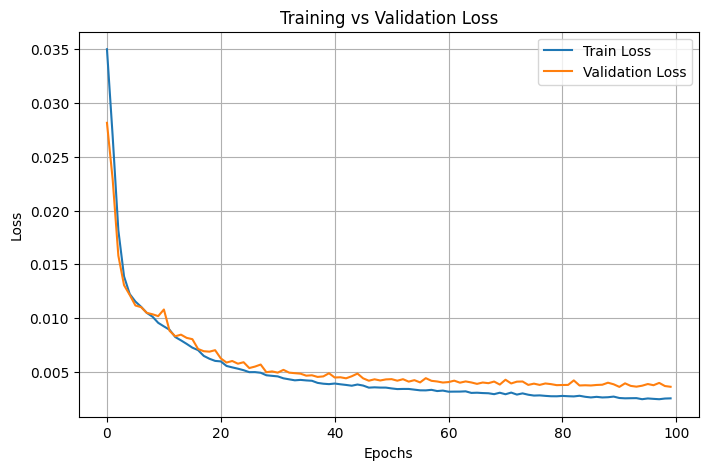

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
y_test_ground_all = np.load("final_y_test_ground.npy")
y_predicted_all = np.load("final_y_test_predicted.npy")

mean_error = np.mean(y_predicted_all - y_test_ground_all)
std_error = np.std(y_predicted_all - y_test_ground_all)

bhs_map = bhs_grades((y_predicted_all - y_test_ground_all))

print(f"Evaluation Results for MAP (test set)")
print(f"ME ± SD MAP (test set): {mean_error:.4f} ± {std_error:.4f}")
print(f"BHS MAP (test set): {bhs_map}")

results = calculate_sbp_dbp_errors(y_test_ground_all, y_predicted_all)

print("\n--- Evaluation Results from Test Set ---")
print(f"SBP MAE: {results['SBP_MAE']:.2f}")
print(f"DBP MAE: {results['DBP_MAE']:.2f}")
print(f"SBP RMSE: {results['SBP_RMSE']:.2f}")
print(f"DBP RMSE: {results['DBP_RMSE']:.2f}")
print(f"SBP ME ± SD: {results['SBP_ME ± SD']}")
print(f"DBP ME ± SD: {results['DBP_ME ± SD']}")
print(f"SBP BHS Grade: {results['SBP_BHS_Grade']}")
print(f"DBP BHS Grade: {results['DBP_BHS_Grade']}")

within_5: 64.96957345971563, within_10: 88.29090047393365, within_15: 95.15740916271722
Evaluation Results for MAP (test set)
ME ± SD MAP (test set): 0.5555 ± 7.4652
BHS MAP (test set): A
within_5: 44.115323854660346, within_10: 72.01816745655609, within_15: 86.09794628751975
within_5: 84.75513428120063, within_10: 96.66271721958925, within_15: 98.67693522906794

--- Evaluation Results from Test Set ---
SBP MAE: 8.09
DBP MAE: 3.12
SBP RMSE: 11.42
DBP RMSE: 4.84
SBP ME ± SD: 4.41 ± 10.54
DBP ME ± SD: -0.47 ± 4.82
SBP BHS Grade: C
DBP BHS Grade: A


## Testing DWT

In [ ]:
dwt_data = np.load("dwt_dataset.npy", allow_pickle=True).item()

ecg_dwt = accumulate_episodes(dwt_data, signal_type='filtered_ecg')
abp_dwt = accumulate_episodes(dwt_data, signal_type='filtered_abp')

X = ecg_dwt
y = abp_dwt

print(f"Shapes of ECG: {X.shape}")
print(f"Shapes of ABP: {y.shape}")

Shapes of ECG: (25319, 625)
Shapes of ABP: (25319, 625)


In [ ]:
results = cross_validate_unet(X, y)

Training fold 1...
Epoch 1/100
64/64 [==============================] - 35s 496ms/step - loss: 0.0360 - mae: 0.1458 - rmse: 0.1825 - val_loss: 0.0279 - val_mae: 0.1343 - val_rmse: 0.1671
Epoch 2/100
64/64 [==============================] - 31s 489ms/step - loss: 0.0272 - mae: 0.1323 - rmse: 0.1650 - val_loss: 0.0273 - val_mae: 0.1332 - val_rmse: 0.1654
Epoch 3/100
64/64 [==============================] - 32s 493ms/step - loss: 0.0242 - mae: 0.1219 - rmse: 0.1551 - val_loss: 0.0196 - val_mae: 0.1029 - val_rmse: 0.1398
Epoch 4/100
64/64 [==============================] - 32s 494ms/step - loss: 0.0160 - mae: 0.0934 - rmse: 0.1264 - val_loss: 0.0145 - val_mae: 0.0880 - val_rmse: 0.1204
Epoch 5/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0132 - mae: 0.0837 - rmse: 0.1149 - val_loss: 0.0124 - val_mae: 0.0808 - val_rmse: 0.1115
Epoch 6/100
64/64 [==============================] - 32s 494ms/step - loss: 0.0118 - mae: 0.0784 - rmse: 0.1084 - val_loss: 0.0119 - val_mae:

In [ ]:
train_losses = results["train_losses"]
val_losses = results["val_losses"]
train_maes = results["train_maes"]
val_maes = results["val_maes"]

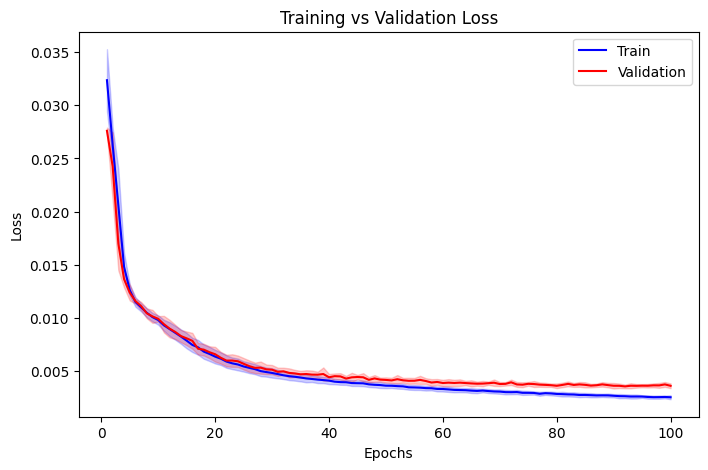

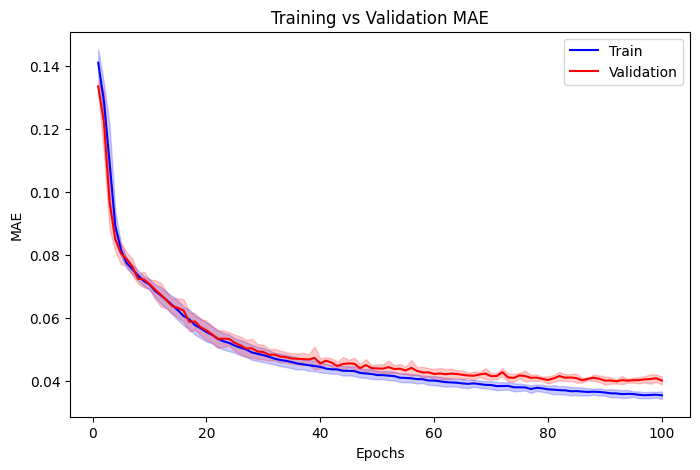

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

train_losses = results["train_losses"]
val_losses = results["val_losses"]
train_maes = results["train_maes"]
val_maes = results["val_maes"]

# Assuming train_losses, val_losses, train_maes, val_maes are lists of lists (one per fold)
train_losses = np.array(train_losses)  # Shape: (n_folds, n_epochs)
val_losses = np.array(val_losses)
train_maes = np.array(train_maes)
val_maes = np.array(val_maes)

epochs = np.arange(1, train_losses.shape[1] + 1)

def plot_metric(train_metric, val_metric, ylabel, title):
    mean_train = np.mean(train_metric, axis=0)
    std_train = np.std(train_metric, axis=0)
    mean_val = np.mean(val_metric, axis=0)
    std_val = np.std(val_metric, axis=0)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, mean_train, label="Train", color="blue")
    plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, color="blue", alpha=0.2)

    plt.plot(epochs, mean_val, label="Validation", color="red")
    plt.fill_between(epochs, mean_val - std_val, mean_val + std_val, color="red", alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Loss Curve
plot_metric(train_losses, val_losses, ylabel="Loss", title="Training vs Validation Loss")

# Plot MAE Curve
plot_metric(train_maes, val_maes, ylabel="MAE", title="Training vs Validation MAE")

#### Train set errors

In [ ]:
evaluate_cv_results(y_test_path="y_train_ground_cv.npy", y_pred_path="y_train_pred_cv.npy")

within_5: 71.67589237225377, within_10: 93.08795852875834, within_15: 97.92322093310294
Evaluation Results for MAP from CV
ME ± SD MAP (CV): -0.2733 ± 5.7020
BHS MAP (CV): A
within_5: 54.38039990125895, within_10: 84.19896321895828, within_15: 95.40730683781781
within_5: 85.31350283880523, within_10: 97.1229326092323, within_15: 98.68674401382374

--- Evaluation Results ---
SBP MAE: 5.68
DBP MAE: 3.07
SBP RMSE: 7.54
DBP RMSE: 4.69
SBP ME ± SD: 1.46 ± 7.39
DBP ME ± SD: -0.19 ± 4.69
SBP BHS Grade: B
DBP BHS Grade: A


#### Validation set errors

In [ ]:
evaluate_cv_results(y_test_path="y_val_ground_cv.npy", y_pred_path="y_val_pred_cv.npy")

within_5: 68.35173932362379, within_10: 90.5632624043446, within_15: 96.3796711922982
Evaluation Results for MAP from CV
ME ± SD MAP (CV): -0.3203 ± 6.8135
BHS MAP (CV): A
within_5: 49.28165884966675, within_10: 78.7114292767218, within_15: 91.50826956307084
within_5: 84.22117995556653, within_10: 96.4848185633177, within_15: 98.32140212293261

--- Evaluation Results ---
SBP MAE: 6.72
DBP MAE: 3.27
SBP RMSE: 9.24
DBP RMSE: 5.29
SBP ME ± SD: 2.18 ± 8.98
DBP ME ± SD: -0.34 ± 5.28
SBP BHS Grade: C
DBP BHS Grade: A


### Test set errors

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

# Final Model Training on Entire Training Data (80% of data)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))


#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Normalize using Min-Max Normalization on the entire training data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train).reshape(-1, 625, 1)
X_val_scaled = scaler_X.transform(X_val).reshape(-1, 625, 1)  # Only transform!
X_test_scaled = scaler_X.transform(X_test).reshape(-1, 625, 1)  # Only transform!

y_train_scaled = scaler_y.fit_transform(y_train).reshape(-1, 625, 1)
y_val_scaled = scaler_y.transform(y_val).reshape(-1, 625, 1)  # Only transform!
y_test_scaled = scaler_y.transform(y_test).reshape(-1, 625, 1)  # Only transform!
# Initialize the model (make sure unet is defined)
model = unet(input_shape=(625, 1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', rmse])

# Train the model on the entire training set (80%)
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled),
                    epochs=100, batch_size=256, verbose=1)#, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_mae, test_rmse = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

# Rescale the predictions and true values to the original scale
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 625))
y_test_true_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 625))

# Calculate final RMSE and MAE on the original scale
final_mae = np.mean(np.abs(y_test_pred_rescaled - y_test_true_rescaled))
final_rmse = np.sqrt(np.mean((y_test_pred_rescaled - y_test_true_rescaled) ** 2))

# Print final evaluation results
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Final Rescaled MAE on Test Set: {final_mae:.4f}")
print(f"Final Rescaled RMSE on Test Set: {final_rmse:.4f}")

# Save the final predictions and true values on the test set
np.save("final_y_test_ground.npy", y_test_true_rescaled)
np.save("final_y_test_predicted.npy", y_test_pred_rescaled)

Epoch 1/100
64/64 [==============================] - 35s 495ms/step - loss: 0.0303 - mae: 0.1380 - rmse: 0.1725 - val_loss: 0.0282 - val_mae: 0.1309 - val_rmse: 0.1679
Epoch 2/100
64/64 [==============================] - 32s 498ms/step - loss: 0.0258 - mae: 0.1270 - rmse: 0.1602 - val_loss: 0.0210 - val_mae: 0.1107 - val_rmse: 0.1448
Epoch 3/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0166 - mae: 0.0958 - rmse: 0.1288 - val_loss: 0.0151 - val_mae: 0.0911 - val_rmse: 0.1227
Epoch 4/100
64/64 [==============================] - 32s 493ms/step - loss: 0.0132 - mae: 0.0839 - rmse: 0.1148 - val_loss: 0.0136 - val_mae: 0.0817 - val_rmse: 0.1167
Epoch 5/100
64/64 [==============================] - 32s 493ms/step - loss: 0.0121 - mae: 0.0797 - rmse: 0.1099 - val_loss: 0.0128 - val_mae: 0.0838 - val_rmse: 0.1132
Epoch 6/100
64/64 [==============================] - 32s 494ms/step - loss: 0.0110 - mae: 0.0757 - rmse: 0.1049 - val_loss: 0.0110 - val_mae: 0.0755 - val_rmse:

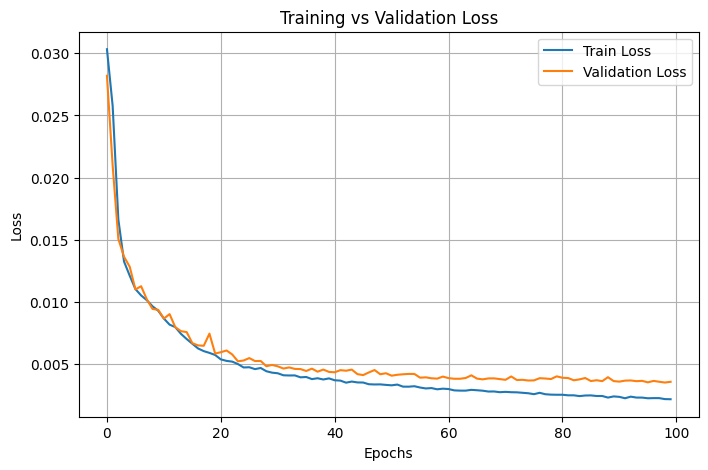

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
y_test_ground_all = np.load("final_y_test_ground.npy")
y_predicted_all = np.load("final_y_test_predicted.npy")

mean_error = np.mean(y_predicted_all - y_test_ground_all)
std_error = np.std(y_predicted_all - y_test_ground_all)

bhs_map = bhs_grades((y_predicted_all - y_test_ground_all))

print(f"Evaluation Results for MAP (test set)")
print(f"ME ± SD MAP (test set): {mean_error:.4f} ± {std_error:.4f}")
print(f"BHS MAP (test set): {bhs_map}")

results = calculate_sbp_dbp_errors(y_test_ground_all, y_predicted_all)

print("\n--- Evaluation Results from Test Set ---")
print(f"SBP MAE: {results['SBP_MAE']:.2f}")
print(f"DBP MAE: {results['DBP_MAE']:.2f}")
print(f"SBP RMSE: {results['SBP_RMSE']:.2f}")
print(f"DBP RMSE: {results['DBP_RMSE']:.2f}")
print(f"SBP ME ± SD: {results['SBP_ME ± SD']}")
print(f"DBP ME ± SD: {results['DBP_ME ± SD']}")
print(f"SBP BHS Grade: {results['SBP_BHS_Grade']}")
print(f"DBP BHS Grade: {results['DBP_BHS_Grade']}")

within_5: 69.14259083728278, within_10: 90.83971563981042, within_15: 96.44454976303317
Evaluation Results for MAP (test set)
ME ± SD MAP (test set): -0.0015 ± 6.7594
BHS MAP (test set): A
within_5: 50.27646129541864, within_10: 79.68009478672985, within_15: 91.4691943127962
within_5: 86.15718799368088, within_10: 96.40600315955766, within_15: 98.61769352290679

--- Evaluation Results from Test Set ---
SBP MAE: 6.65
DBP MAE: 3.07
SBP RMSE: 9.50
DBP RMSE: 4.79
SBP ME ± SD: 2.58 ± 9.15
DBP ME ± SD: -0.30 ± 4.78
SBP BHS Grade: B
DBP BHS Grade: A


## Testing NK2

In [ ]:
nk_data = np.load("neurokit_dataset.npy", allow_pickle=True).item()

ecg_nk = accumulate_episodes(nk_data, signal_type='filtered_ecg')
abp_nk = accumulate_episodes(nk_data, signal_type='filtered_abp')

X = ecg_nk
y = abp_nk

print(f"Shapes of ECG: {X.shape}")
print(f"Shapes of ABP: {y.shape}")

Shapes of ECG: (25319, 625)
Shapes of ABP: (25319, 625)


In [ ]:
results = cross_validate_unet(X, y)

Training fold 1...
Epoch 1/100
64/64 [==============================] - 35s 499ms/step - loss: 0.0299 - mae: 0.1374 - rmse: 0.1715 - val_loss: 0.0277 - val_mae: 0.1345 - val_rmse: 0.1666
Epoch 2/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0234 - mae: 0.1192 - rmse: 0.1525 - val_loss: 0.0190 - val_mae: 0.1048 - val_rmse: 0.1377
Epoch 3/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0159 - mae: 0.0932 - rmse: 0.1259 - val_loss: 0.0150 - val_mae: 0.0889 - val_rmse: 0.1222
Epoch 4/100
64/64 [==============================] - 32s 496ms/step - loss: 0.0132 - mae: 0.0837 - rmse: 0.1146 - val_loss: 0.0130 - val_mae: 0.0843 - val_rmse: 0.1140
Epoch 5/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0119 - mae: 0.0793 - rmse: 0.1091 - val_loss: 0.0117 - val_mae: 0.0788 - val_rmse: 0.1080
Epoch 6/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0112 - mae: 0.0766 - rmse: 0.1056 - val_loss: 0.0112 - val_mae:

In [ ]:
train_losses = results["train_losses"]
val_losses = results["val_losses"]
train_maes = results["train_maes"]
val_maes = results["val_maes"]

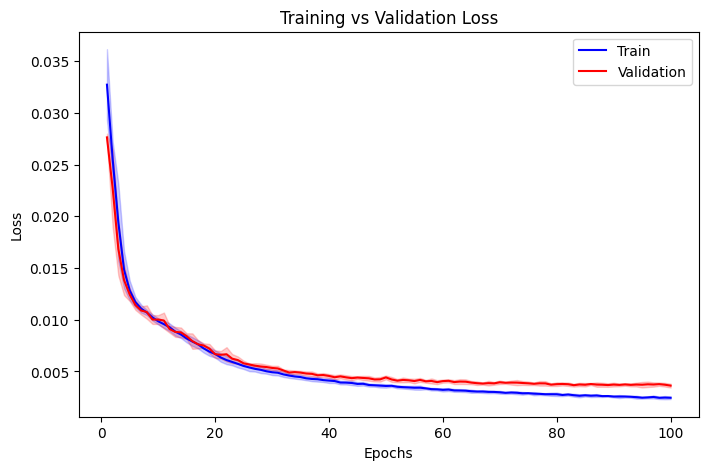

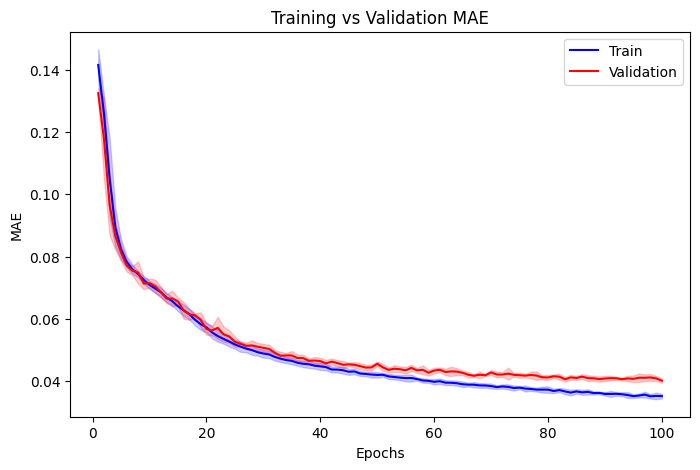

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_losses, val_losses, train_maes, val_maes are lists of lists (one per fold)
train_losses = np.array(train_losses)  # Shape: (n_folds, n_epochs)
val_losses = np.array(val_losses)
train_maes = np.array(train_maes)
val_maes = np.array(val_maes)

epochs = np.arange(1, train_losses.shape[1] + 1)

def plot_metric(train_metric, val_metric, ylabel, title):
    mean_train = np.mean(train_metric, axis=0)
    std_train = np.std(train_metric, axis=0)
    mean_val = np.mean(val_metric, axis=0)
    std_val = np.std(val_metric, axis=0)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, mean_train, label="Train", color="blue")
    plt.fill_between(epochs, mean_train - std_train, mean_train + std_train, color="blue", alpha=0.2)

    plt.plot(epochs, mean_val, label="Validation", color="red")
    plt.fill_between(epochs, mean_val - std_val, mean_val + std_val, color="red", alpha=0.2)

    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Plot Loss Curve
plot_metric(train_losses, val_losses, ylabel="Loss", title="Training vs Validation Loss")

# Plot MAE Curve
plot_metric(train_maes, val_maes, ylabel="MAE", title="Training vs Validation MAE")

#### Train set errors

In [ ]:
evaluate_cv_results(y_test_path="y_train_ground_cv.npy", y_pred_path="y_train_pred_cv.npy")

within_5: 72.78886793384349, within_10: 93.65337348802765, within_15: 98.18464971611948
Evaluation Results for MAP from CV
ME ± SD MAP (CV): -0.0482 ± 5.5293
BHS MAP (CV): A
within_5: 54.98889163169588, within_10: 84.9012589484078, within_15: 95.7430264132313
within_5: 85.32337694396446, within_10: 97.29943223895334, within_15: 98.7645025919526

--- Evaluation Results ---
SBP MAE: 5.58
DBP MAE: 3.08
SBP RMSE: 7.40
DBP RMSE: 4.62
SBP ME ± SD: 2.27 ± 7.05
DBP ME ± SD: -0.15 ± 4.61
SBP BHS Grade: B
DBP BHS Grade: A


#### Validation set errors

In [ ]:
evaluate_cv_results(y_test_path="y_val_ground_cv.npy", y_pred_path="y_val_pred_cv.npy")

within_5: 68.52600543075783, within_10: 90.551255492471, within_15: 96.34779758084424
Evaluation Results for MAP from CV
ME ± SD MAP (CV): -0.1053 ± 6.8490
BHS MAP (CV): A
within_5: 48.73858306590965, within_10: 77.50185139471736, within_15: 90.83683041224388
within_5: 83.25845470254258, within_10: 96.47988151073808, within_15: 98.43001727968402

--- Evaluation Results ---
SBP MAE: 6.87
DBP MAE: 3.33
SBP RMSE: 9.47
DBP RMSE: 5.31
SBP ME ± SD: 3.14 ± 8.93
DBP ME ± SD: -0.33 ± 5.30
SBP BHS Grade: C
DBP BHS Grade: A


### Test set errors

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

In [ ]:
#from tensorflow.keras.callbacks import EarlyStopping

# Final Model Training on Entire Training Data (80% of data)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))


#early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Normalize using Min-Max Normalization on the entire training data
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_train_scaled = scaler_X.fit_transform(X_train).reshape(-1, 625, 1)
X_val_scaled = scaler_X.transform(X_val).reshape(-1, 625, 1)  # Only transform!
X_test_scaled = scaler_X.transform(X_test).reshape(-1, 625, 1)  # Only transform!

y_train_scaled = scaler_y.fit_transform(y_train).reshape(-1, 625, 1)
y_val_scaled = scaler_y.transform(y_val).reshape(-1, 625, 1)  # Only transform!
y_test_scaled = scaler_y.transform(y_test).reshape(-1, 625, 1)  # Only transform!
# Initialize the model (make sure unet is defined)
model = unet(input_shape=(625, 1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', rmse])

# Train the model on the entire training set (80%)
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_val_scaled, y_val_scaled),
                    epochs=100, batch_size=256, verbose=1)#, callbacks=[early_stopping])

# Evaluate the model on the test set
test_loss, test_mae, test_rmse = model.evaluate(X_test_scaled, y_test_scaled, verbose=0)

# Rescale the predictions and true values to the original scale
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred_rescaled = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 625))
y_test_true_rescaled = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 625))

# Calculate final RMSE and MAE on the original scale
final_mae = np.mean(np.abs(y_test_pred_rescaled - y_test_true_rescaled))
final_rmse = np.sqrt(np.mean((y_test_pred_rescaled - y_test_true_rescaled) ** 2))

# Print final evaluation results
print(f"Test MAE: {test_mae:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Final Rescaled MAE on Test Set: {final_mae:.4f}")
print(f"Final Rescaled RMSE on Test Set: {final_rmse:.4f}")

# Save the final predictions and true values on the test set
np.save("final_y_test_ground.npy", y_test_true_rescaled)
np.save("final_y_test_predicted.npy", y_test_pred_rescaled)

Epoch 1/100
64/64 [==============================] - 35s 497ms/step - loss: 0.0293 - mae: 0.1362 - rmse: 0.1703 - val_loss: 0.0278 - val_mae: 0.1346 - val_rmse: 0.1667
Epoch 2/100
64/64 [==============================] - 32s 493ms/step - loss: 0.0245 - mae: 0.1224 - rmse: 0.1561 - val_loss: 0.0196 - val_mae: 0.1066 - val_rmse: 0.1400
Epoch 3/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0168 - mae: 0.0963 - rmse: 0.1294 - val_loss: 0.0145 - val_mae: 0.0887 - val_rmse: 0.1205
Epoch 4/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0131 - mae: 0.0833 - rmse: 0.1142 - val_loss: 0.0126 - val_mae: 0.0812 - val_rmse: 0.1122
Epoch 5/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0117 - mae: 0.0783 - rmse: 0.1080 - val_loss: 0.0116 - val_mae: 0.0779 - val_rmse: 0.1074
Epoch 6/100
64/64 [==============================] - 32s 495ms/step - loss: 0.0109 - mae: 0.0752 - rmse: 0.1041 - val_loss: 0.0116 - val_mae: 0.0757 - val_rmse:

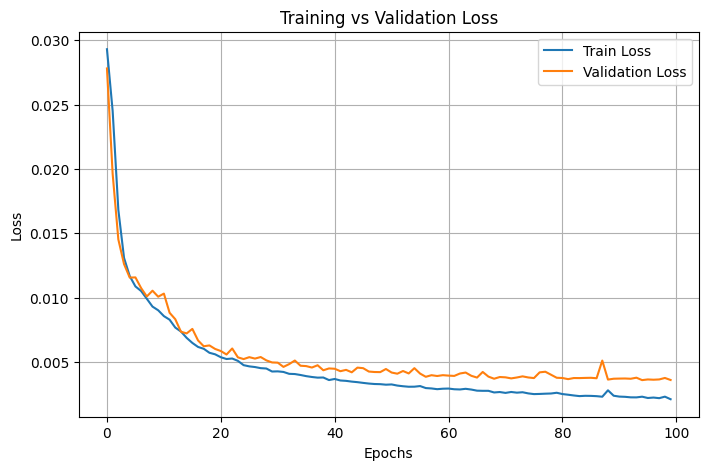

In [ ]:
# Plot training vs validation loss
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [ ]:
y_test_ground_all = np.load("final_y_test_ground.npy")
y_predicted_all = np.load("final_y_test_predicted.npy")

mean_error = np.mean(y_predicted_all - y_test_ground_all)
std_error = np.std(y_predicted_all - y_test_ground_all)

bhs_map = bhs_grades((y_predicted_all - y_test_ground_all))

print(f"Evaluation Results for MAP (test set)")
print(f"ME ± SD MAP (test set): {mean_error:.4f} ± {std_error:.4f}")
print(f"BHS MAP (test set): {bhs_map}")

results = calculate_sbp_dbp_errors(y_test_ground_all, y_predicted_all)

print("\n--- Evaluation Results from Test Set ---")
print(f"SBP MAE: {results['SBP_MAE']:.2f}")
print(f"DBP MAE: {results['DBP_MAE']:.2f}")
print(f"SBP RMSE: {results['SBP_RMSE']:.2f}")
print(f"DBP RMSE: {results['DBP_RMSE']:.2f}")
print(f"SBP ME ± SD: {results['SBP_ME ± SD']}")
print(f"DBP ME ± SD: {results['DBP_ME ± SD']}")
print(f"SBP BHS Grade: {results['SBP_BHS_Grade']}")
print(f"DBP BHS Grade: {results['DBP_BHS_Grade']}")

within_5: 68.69336492890994, within_10: 90.57684044233807, within_15: 96.318672985782
Evaluation Results for MAP (test set)
ME ± SD MAP (test set): -0.0374 ± 6.8125
BHS MAP (test set): A
within_5: 45.359399684044234, within_10: 74.86176935229068, within_15: 88.94154818325435
within_5: 85.20932069510269, within_10: 96.7219589257504, within_15: 98.67693522906794

--- Evaluation Results from Test Set ---
SBP MAE: 7.49
DBP MAE: 3.13
SBP RMSE: 10.43
DBP RMSE: 4.82
SBP ME ± SD: 3.74 ± 9.73
DBP ME ± SD: -0.13 ± 4.82
SBP BHS Grade: C
DBP BHS Grade: A
